# Notebook 2 
## Sleep Detection - Model Training
In <b>Notebook 1 Sleep Detection - EDA</b> we have:
- explored the data to see if values are as expected from the description,
- checked if we have missing values,
- calculated correlations and saved highly correlated features into a file -> <b>"features_to_exclude.txt"</b>

In this notebook we continue with:
- defining our metrics,
- shuffle the data and split into training, validation and test set,
- training the first basic Decision Tree model,
- tuning Decision Tree hyperparameters,
- training and tuning XGBoost model.

In [1]:
import pandas as pd
import numpy as np
import datetime

import polars as pl
pl.Config.set_fmt_str_lengths(100)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

import xgboost as xgb

from helpers import create_rolling_features, concat_in_order

#### Loading the dataset
- Load and check it again, first few rows and if it contains nulls.

In [2]:
train_data_file = 'child-mind-institute-detect-sleep-states/sleep_data_120_series.csv'
df = pl.read_csv(train_data_file, dtypes={
    "dt_minute":pl.Datetime
}).sort(by=["series_id","dt_minute"])

In [3]:
df.head()

series_id,step,dt_minute,anglez,enmo,target
str,i64,datetime[μs],i64,i64,i64
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,15,0
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,15,0
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,19,0
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,14,0
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,14,0


In [4]:
df.select(pl.all().is_null().sum())

series_id,step,dt_minute,anglez,enmo,target
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


#### Create "hour" feature

In [5]:
df = df.with_columns(
    pl.col('dt_minute').dt.hour().cast(pl.UInt8).alias('hour')
)

#### Calculate rolling features

In [6]:
df = create_rolling_features(df)

In [7]:
df.head()

series_id,step,dt_minute,anglez,enmo,target,hour,enmo_15m_mean,enmo_15m_max,enmo_15m_min,enmo_15m_std,enmo_diffs_15m_sum,anglez_15m_mean,anglez_15m_max,anglez_15m_min,anglez_15m_std,anglez_diffs_15m_sum,enmo_60m_mean,enmo_60m_max,enmo_60m_min,enmo_60m_std,enmo_diffs_60m_sum,anglez_60m_mean,anglez_60m_max,anglez_60m_min,anglez_60m_std,anglez_diffs_60m_sum,enmo_180m_mean,enmo_180m_max,enmo_180m_min,enmo_180m_std,enmo_diffs_180m_sum,anglez_180m_mean,anglez_180m_max,anglez_180m_min,anglez_180m_std,anglez_diffs_180m_sum,enmo_480m_mean,enmo_480m_max,enmo_480m_min,enmo_480m_std,enmo_diffs_480m_sum,anglez_480m_mean,anglez_480m_max,anglez_480m_min,anglez_480m_std,anglez_diffs_480m_sum,enmo_diffs_sum_div_max_min_15m,anglez_diffs_sum_div_max_min_15m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_180m,anglez_diffs_sum_div_max_min_180m,enmo_diffs_sum_div_max_min_480m,anglez_diffs_sum_div_max_min_480m
str,i64,datetime[μs],i64,i64,i64,u8,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""05e1944c3818""",0,2018-11-16 18:00:00,-86,15,0,18,15.0,19,14,1.690309,2.070197,-86.0,-86,-86,0.0,0.0,14.366667,19,13,1.217214,1.465532,-86.0,-83,-87,0.909718,0.775232,61.066667,425,6,83.150709,52.238771,-38.111111,17,-87,41.805178,8.793642,73.141667,425,0,81.16833,51.104065,-22.241667,63,-87,31.913585,12.243604,0.345033,0.0,0.209362,0.155046,0.124378,0.083749,0.119963,0.081083
"""05e1944c3818""",12,2018-11-16 18:01:00,-86,15,0,18,14.888889,19,14,1.615893,1.995531,-86.0,-86,-86,0.0,0.0,14.354839,19,13,1.198565,1.440386,-86.032258,-83,-87,0.912282,0.76489,61.637363,425,6,82.866495,52.443828,-37.857143,17,-87,41.642812,8.852664,73.024896,425,0,81.019335,51.057749,-22.153527,63,-87,31.87641,12.238203,0.332588,0.0,0.205769,0.152978,0.124866,0.084311,0.119854,0.081048
"""05e1944c3818""",24,2018-11-16 18:02:00,-86,19,0,18,14.8,19,14,1.549193,1.922094,-86.0,-86,-86,0.0,0.0,14.34375,19,13,1.180743,1.424064,-86.0625,-83,-87,0.913607,0.754912,61.26087,425,6,82.48901,52.43287,-37.543478,17,-87,41.522512,8.803346,72.842975,425,0,80.900585,50.973559,-22.041322,63,-87,31.858061,12.2156,0.320349,0.0,0.203438,0.150982,0.12484,0.083841,0.119656,0.080898
"""05e1944c3818""",36,2018-11-16 18:03:00,-86,14,0,18,14.727273,19,14,1.489356,1.852926,-86.0,-86,-86,0.0,0.0,14.333333,19,13,1.163687,1.408142,-86.090909,-83,-87,0.913908,0.745281,60.978495,425,6,82.084657,52.218984,-37.247312,17,-87,41.394879,8.770553,73.078189,425,0,80.816482,51.022072,-22.012346,63,-87,31.795379,12.206735,0.308821,0.0,0.201163,0.149056,0.124331,0.083529,0.11977,0.080839
"""05e1944c3818""",48,2018-11-16 18:04:00,-86,14,0,18,14.666667,19,14,1.435481,1.788854,-86.0,-86,-86,0.0,0.0,14.352941,19,13,1.151609,1.386488,-86.117647,-83,-87,0.913359,0.73598,60.425532,425,6,81.817984,51.941965,-36.851064,17,-87,41.350575,8.73272,73.032787,425,0,80.65314,50.949226,-21.836066,63,-87,31.849146,12.293673,0.298142,0.0,0.19807,0.147196,0.123671,0.083169,0.119599,0.081415


### Split into training, validation and test set.

In [8]:
# We need to split by series_id to be able to calculate rolling variables
# Shuffle series id's
series_ids_shuffle = df["series_id"].unique().sort().shuffle(seed=4)

# Determine sizes
test_val_set_size = int(series_ids_shuffle.shape[0] * 0.2)
train_set_size = series_ids_shuffle.shape[0] - 2 * test_val_set_size

# Select sets
df_train_night_ids = series_ids_shuffle[:train_set_size]
df_val_night_ids = series_ids_shuffle[train_set_size:train_set_size+test_val_set_size]
df_test_night_ids = series_ids_shuffle[train_set_size+test_val_set_size:]

df_train = df.filter(pl.col('series_id').is_in(df_train_night_ids))
df_val = df.filter(pl.col('series_id').is_in(df_val_night_ids))
df_test = df.filter(pl.col('series_id').is_in(df_test_night_ids))

In [9]:
df_train = create_rolling_features(df_train)
df_val = create_rolling_features(df_val)
df_test = create_rolling_features(df_test)

#### Read features to exclude that are highly correlated with some other features
- We have found them in <b>sleep_detection_eda.ipynb notebook</b>.

In [10]:
with open('features_to_exclude.txt') as f:
    vars_to_exclude = [line.rstrip() for line in f]

vars_to_exclude

['enmo_15m_max',
 'enmo_60m_max',
 'enmo_180m_max',
 'enmo_480m_max',
 'enmo_diffs_15m_sum',
 'enmo_diffs_60m_sum',
 'enmo_diffs_180m_sum',
 'enmo_diffs_480m_sum',
 'anglez',
 'anglez_15m_mean',
 'anglez_15m_std',
 'enmo_15m_mean',
 'enmo_60m_mean',
 'enmo_60m_mean',
 'enmo_180m_mean',
 'enmo_480m_mean']

In [11]:
df_train = df_train.drop(vars_to_exclude)
df_val = df_val.drop(vars_to_exclude)
df_test = df_test.drop(vars_to_exclude)

### Transform to pandas

In [12]:
df_train_all_pd = df_train.to_pandas()
df_val_all_pd = df_val.to_pandas()
df_test_all_pd = df_test.to_pandas()

labels = "target"
y_train = df_train_all_pd[labels].values
y_val = df_val_all_pd[labels].values
y_test = df_test_all_pd[labels].values

del df_train_all_pd[labels] 
del df_val_all_pd[labels]
del df_test_all_pd[labels]

features = [f for f in df_train_all_pd.columns if f not in ["dt_minute","step","series_id"]]
features

['enmo',
 'hour',
 'enmo_15m_min',
 'enmo_15m_std',
 'anglez_15m_max',
 'anglez_15m_min',
 'anglez_diffs_15m_sum',
 'enmo_60m_min',
 'enmo_60m_std',
 'anglez_60m_mean',
 'anglez_60m_max',
 'anglez_60m_min',
 'anglez_60m_std',
 'anglez_diffs_60m_sum',
 'enmo_180m_min',
 'enmo_180m_std',
 'anglez_180m_mean',
 'anglez_180m_max',
 'anglez_180m_min',
 'anglez_180m_std',
 'anglez_diffs_180m_sum',
 'enmo_480m_min',
 'enmo_480m_std',
 'anglez_480m_mean',
 'anglez_480m_max',
 'anglez_480m_min',
 'anglez_480m_std',
 'anglez_diffs_480m_sum',
 'enmo_diffs_sum_div_max_min_15m',
 'anglez_diffs_sum_div_max_min_15m',
 'enmo_diffs_sum_div_max_min_60m',
 'anglez_diffs_sum_div_max_min_60m',
 'enmo_diffs_sum_div_max_min_180m',
 'anglez_diffs_sum_div_max_min_180m',
 'enmo_diffs_sum_div_max_min_480m',
 'anglez_diffs_sum_div_max_min_480m']

In [13]:
X_train = df_train_all_pd[features]
X_val = df_val_all_pd[features]
X_test = df_test_all_pd[features]

## Metrics
- This is a classification problem so we will calculate accuracy.
- However, our goal is to determine <b>sleep state</b> so we will also calculate precision, recall and F1 score for sleep.
- Our priority will be <b>sleep F1 score metric</b>.  

#### Precision, recall and F1 score

In [14]:
def calculate_metrics(target):
    precision = sum((y_pred==y_val) & (y_val==target)) / sum(y_pred==target)
    recall = sum((y_pred==y_val) & (y_val==target)) / sum(y_val==target)
    f1_score = 2 / ((1/precision) + (1/recall))
    return precision, recall, f1_score

## Model 1: Decision tree

Let's start with a very simple tree of depth 2.

In [15]:
model = DecisionTreeClassifier(max_depth=2, random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [16]:
model.classes_

array([0, 1, 2])

In [17]:
print(export_text(model, feature_names=features))

|--- enmo_60m_std <= 17.31
|   |--- anglez_480m_std <= 26.10
|   |   |--- class: 0
|   |--- anglez_480m_std >  26.10
|   |   |--- class: 1
|--- enmo_60m_std >  17.31
|   |--- hour <= 6.50
|   |   |--- class: 0
|   |--- hour >  6.50
|   |   |--- class: 0



In [18]:
y_pred = model.predict(X_val)

In [22]:
accuracy = sum(y_val == y_pred) / y_pred.size
sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(target=1)

In [23]:
print(
    f"Accuracy: \t\t {accuracy.round(3)}"
    f"\nSleep precision: \t {sleep_precision.round(3)}" 
    f"\nSleep recall: \t\t {sleep_recall.round(3)} "
    f"\nSleep F1 score: \t {sleep_f1_score.round(3)}"
)

Accuracy: 		 0.766
Sleep precision: 	 0.746
Sleep recall: 		 0.828 
Sleep F1 score: 	 0.785


We can see that even this simple tree gives us decent results.

However, we will try to improve.

### Decision tree - hyperparameter tuning
- Parameters that will be tuned:
    - max_depth
    - min_samples_split 

In [24]:
max_depth_s = [2,6,8,10]
min_samples_split_s = [100, 150, 200]

In [25]:
results = []
for max_depth in max_depth_s:
    for min_samples_split in min_samples_split_s:
        print(f"growing tree with max_depth: {max_depth} and min_sampes_split: {min_samples_split} ...")
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = sum(y_val == y_pred) / y_pred.size
        sleep_precision, sleep_recall, sleep_f1_score = calculate_metrics(target=1)
        results.append({
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "accuracy": accuracy,
            "sleep_precision": sleep_precision,
            "sleep_recall": sleep_recall,
            "sleep_f1_score": sleep_f1_score
        })

growing tree with max_depth: 2 and min_sampes_split: 100 ...
growing tree with max_depth: 2 and min_sampes_split: 150 ...
growing tree with max_depth: 2 and min_sampes_split: 200 ...
growing tree with max_depth: 6 and min_sampes_split: 100 ...
growing tree with max_depth: 6 and min_sampes_split: 150 ...
growing tree with max_depth: 6 and min_sampes_split: 200 ...
growing tree with max_depth: 8 and min_sampes_split: 100 ...
growing tree with max_depth: 8 and min_sampes_split: 150 ...
growing tree with max_depth: 8 and min_sampes_split: 200 ...
growing tree with max_depth: 10 and min_sampes_split: 100 ...
growing tree with max_depth: 10 and min_sampes_split: 150 ...
growing tree with max_depth: 10 and min_sampes_split: 200 ...


In [26]:
results_pd = pd.DataFrame(results).set_index(["max_depth","min_samples_split"])

In [27]:
results_pd.sort_values(by="sleep_f1_score", ascending=False).style.format(precision=4).background_gradient(subset=["sleep_f1_score"], axis=0)

The best sleep F1 score is obtained for decision tree with max_depth=8 and min_sample_split=100.

Our best sleep F1 score is equal to <b>0.9421<b>.

### Decision tree - best probability threshold 

## Model 2: XGBoost

In [190]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [191]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [201]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 5,
    # 'gamma': 1
    'min_child_weight': 1,
    'objective': 'multi:softprob', 
    'num_class': 3,
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

In [206]:
model = xgb.train(
    xgb_params, 
    dtrain,
    evals=watchlist,
    verbose_eval=10, #print every 10 step
    num_boost_round=50 # with more we overfit
)

[0]	train-auc:0.99793	val-auc:0.98668
[10]	train-auc:0.99985	val-auc:0.99311
[20]	train-auc:0.99996	val-auc:0.99333
[30]	train-auc:0.99999	val-auc:0.99304
[40]	train-auc:1.00000	val-auc:0.99291
[49]	train-auc:1.00000	val-auc:0.99284


In [207]:
y_pred_proba = model.predict(dval)
y_pred_proba

array([[9.3839914e-01, 6.1455410e-02, 1.4543331e-04],
       [9.5844406e-01, 4.1432884e-02, 1.2306393e-04],
       [9.7140044e-01, 2.8555434e-02, 4.4092005e-05],
       ...,
       [3.4987901e-05, 1.9082288e-06, 9.9996305e-01],
       [3.8476497e-05, 2.0984958e-06, 9.9995947e-01],
       [2.2661241e-04, 1.4047616e-05, 9.9975938e-01]], dtype=float32)

In [208]:
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

array([0, 0, 0, ..., 2, 2, 2])

In [210]:
sum(y_val == y_pred) / y_pred.size

0.9657136577592996

0.9671348314606741

In [212]:
sleep_precision, sleep_recall, f1_score = calculate_metrics(target=1)

In [213]:
print(f"Sleep precision: \t {sleep_precision.round(3)} \nSleep recall: \t\t {sleep_recall.round(3)} \nSleep F1 score: \t {f1_score.round(3)}")

Sleep precision: 	 0.908 
Sleep recall: 		 0.983 
Sleep F1 score: 	 0.944


### Test set performance

In [214]:
y_test_proba = model.predict(dtest)
y_test_pred = np.argmax(y_test_proba, axis=1)
sum(y_test == y_test_pred) / y_test.size

0.9727882453992215

In [56]:
def add_predictions(df,predictions):
    y_pred = np.argmax(predictions, axis=1)
    df["prediction"] = y_pred
    df["probability"] = predictions[:,1]
    df = df.copy()
    return df

In [57]:
df_test_all_pd = add_predictions(df_test_all_pd, predictions=y_test_proba)

/tmp/ipykernel_8939/2163078458.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["prediction"] = y_pred
/tmp/ipykernel_8939/2163078458.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["probability"] = predictions[:,1]


In [59]:
df_test_all_pd = clean_predictions(df_test_all_pd)
df_test_all_pd.head()

series_id,dt_minute,anglez_mean,anglez_std,anglez_max,anglez_min,enmo_mean,enmo_max,enmo_min,anglez_1st_diffs_sum,enmo_1st_diffs_sum,step_min,hour,enmo_mean_5m_mean,enmo_mean_5m_max,enmo_mean_5m_min,enmo_min_5m_mean,enmo_min_5m_max,enmo_min_5m_min,enmo_max_5m_mean,enmo_max_5m_max,enmo_max_5m_min,anglez_mean_5m_mean,anglez_mean_5m_max,anglez_mean_5m_min,anglez_std_5m_mean,anglez_std_5m_max,anglez_std_5m_min,anglez_min_5m_mean,anglez_min_5m_max,anglez_min_5m_min,anglez_max_5m_mean,anglez_max_5m_max,anglez_max_5m_min,enmo_mean_15m_mean,enmo_mean_15m_max,enmo_mean_15m_min,…,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_120m,enmo_diffs_sum_div_max_min_120m,anglez_diffs_sum_div_max_min_240m,enmo_diffs_sum_div_max_min_240m,night_start_date,night_id,enmo_max_15m_min,anglez_std_30m_min,anglez_min_30m_max,anglez_max_30m_min,anglez_min_60m_max,anglez_max_60m_min,enmo_min_240m_max,enmo_max_240m_min,enmo_min_480m_mean,anglez_std_480m_min,anglez_min_480m_mean,anglez_max_480m_mean,anglez_max_480m_min,enmo_min_1v_480m_mean,enmo_min_1v_480m_max,enmo_max_1v_480m_max,anglez_max_1v_480m_mean,anglez_max_min_diff_5m,anglez_max_min_diff_480m,anglez_diffs_sum_div_max_min_480m,enmo_diffs_sum_div_max_min_480m,prediction,probability,day,notwear,notwear_daily,long_sleep,long_sleep_start,long_sleep_end
str,datetime[ns],i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,…,f64,f64,f64,f64,f64,f64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,i64,f64,f64,i64,f32,datetime[ns],i32,i32,i64,i64,i64
"""08db4255286f""",2018-11-06 12:00:00,-22,29.719,19,-59,94,222,7,103,588,18720,12,123.666667,152,94,11.333333,19,7,315.666667,488,222,-8.0,0,-22,22.576,29.719,12.063,-52.0,-29,-68,17.333333,22,11,182.875,404,94,…,33.855856,26.654947,44.410853,31.530513,104.821705,36.996107,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,2,-12,-24,88,4,15.720833,0.853,-53.370833,-7.541667,-83,113.430962,810,14800,166.736402,90,165,168.5,77.356507,0,0.000052,2018-11-06 00:00:00,0,0,null,null,null
"""08db4255286f""",2018-11-06 12:01:00,-2,12.063,11,-29,152,488,19,117,1130,18732,12,148.5,223,94,19.0,42,7,449.0,849,222,-10.5,0,-22,21.19175,29.719,12.063,-49.75,-29,-68,14.75,22,7,176.111111,404,94,…,34.882883,27.028571,44.682171,31.616762,105.821705,37.893215,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-6,-12,-24,88,4,15.659751,0.853,-53.481328,-7.568465,-83,113.0,810,14800,166.291667,90,165,169.246988,77.447164,0,0.000052,2018-11-06 00:00:00,0,0,null,null,null
"""08db4255286f""",2018-11-06 12:02:00,0,25.946,22,-68,125,237,8,181,981,18744,12,166.6,239,94,32.8,88,7,478.4,849,222,-8.2,1,-22,18.1176,29.719,5.821,-42.2,-12,-68,13.6,22,7,178.5,404,94,…,33.854701,27.123265,45.054264,31.951993,106.930233,38.857063,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-25,88,4,15.599174,0.853,-53.454545,-7.413223,-83,112.53112,810,14800,167.427386,90,165,170.825301,77.529477,0,0.000052,2018-11-06 00:00:00,0,0,null,null,null
"""08db4255286f""",2018-11-06 12:03:00,-18,17.039,7,-43,223,849,42,253,1795,18756,12,228.6,404,125,37.6,88,8,679.6,1228,237,-3.8,1,-18,13.5986,25.946,5.821,-33.0,-12,-68,12.4,22,7,177.363636,404,94,…,35.196581,27.502447,45.906977,32.062653,108.093023,39.316463,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-25,88,4,15.539095,0.853,-53.411523,-7.407407,-83,112.066116,810,14800,168.22314,90,165,171.349398,77.584538,0,0.000052,2018-11-06 00:00:00,0,0,null,null,null
"""08db4255286f""",2018-11-06 12:04:00,1,5.821,9,-12,239,596,88,65,1855,18768,12,223.0,404,124,38.8,88,8,662.8,1228,237,-4.4,1,-18,13.3432,25.946,5.821,-31.6,-12,-68,12.4,22,7,171.833333,404,94,…,36.017094,28.414356,46.418605,32.152156,109.031008,39.646274,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-46,88,4,15.47541,0.853,-53.340164,-7.213115,-83,111.646091,810,

In [60]:
dt_test_all_pd = df_test_all_pd.with_columns(pl.col("long_sleep").fill_null(0))
dt_test_all_pd.head()

series_id,dt_minute,anglez_mean,anglez_std,anglez_max,anglez_min,enmo_mean,enmo_max,enmo_min,anglez_1st_diffs_sum,enmo_1st_diffs_sum,step_min,hour,enmo_mean_5m_mean,enmo_mean_5m_max,enmo_mean_5m_min,enmo_min_5m_mean,enmo_min_5m_max,enmo_min_5m_min,enmo_max_5m_mean,enmo_max_5m_max,enmo_max_5m_min,anglez_mean_5m_mean,anglez_mean_5m_max,anglez_mean_5m_min,anglez_std_5m_mean,anglez_std_5m_max,anglez_std_5m_min,anglez_min_5m_mean,anglez_min_5m_max,anglez_min_5m_min,anglez_max_5m_mean,anglez_max_5m_max,anglez_max_5m_min,enmo_mean_15m_mean,enmo_mean_15m_max,enmo_mean_15m_min,…,anglez_diffs_sum_div_max_min_60m,enmo_diffs_sum_div_max_min_60m,anglez_diffs_sum_div_max_min_120m,enmo_diffs_sum_div_max_min_120m,anglez_diffs_sum_div_max_min_240m,enmo_diffs_sum_div_max_min_240m,night_start_date,night_id,enmo_max_15m_min,anglez_std_30m_min,anglez_min_30m_max,anglez_max_30m_min,anglez_min_60m_max,anglez_max_60m_min,enmo_min_240m_max,enmo_max_240m_min,enmo_min_480m_mean,anglez_std_480m_min,anglez_min_480m_mean,anglez_max_480m_mean,anglez_max_480m_min,enmo_min_1v_480m_mean,enmo_min_1v_480m_max,enmo_max_1v_480m_max,anglez_max_1v_480m_mean,anglez_max_min_diff_5m,anglez_max_min_diff_480m,anglez_diffs_sum_div_max_min_480m,enmo_diffs_sum_div_max_min_480m,prediction,probability,day,notwear,notwear_daily,long_sleep,long_sleep_start,long_sleep_end
str,datetime[ns],i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,…,f64,f64,f64,f64,f64,f64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,i64,f64,f64,i64,f32,datetime[ns],i32,i32,i64,i64,i64
"""08db4255286f""",2018-11-06 12:00:00,-22,29.719,19,-59,94,222,7,103,588,18720,12,123.666667,152,94,11.333333,19,7,315.666667,488,222,-8.0,0,-22,22.576,29.719,12.063,-52.0,-29,-68,17.333333,22,11,182.875,404,94,…,33.855856,26.654947,44.410853,31.530513,104.821705,36.996107,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,2,-12,-24,88,4,15.720833,0.853,-53.370833,-7.541667,-83,113.430962,810,14800,166.736402,90,165,168.5,77.356507,0,0.000052,2018-11-06 00:00:00,0,0,0,null,null
"""08db4255286f""",2018-11-06 12:01:00,-2,12.063,11,-29,152,488,19,117,1130,18732,12,148.5,223,94,19.0,42,7,449.0,849,222,-10.5,0,-22,21.19175,29.719,12.063,-49.75,-29,-68,14.75,22,7,176.111111,404,94,…,34.882883,27.028571,44.682171,31.616762,105.821705,37.893215,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-6,-12,-24,88,4,15.659751,0.853,-53.481328,-7.568465,-83,113.0,810,14800,166.291667,90,165,169.246988,77.447164,0,0.000052,2018-11-06 00:00:00,0,0,0,null,null
"""08db4255286f""",2018-11-06 12:02:00,0,25.946,22,-68,125,237,8,181,981,18744,12,166.6,239,94,32.8,88,7,478.4,849,222,-8.2,1,-22,18.1176,29.719,5.821,-42.2,-12,-68,13.6,22,7,178.5,404,94,…,33.854701,27.123265,45.054264,31.951993,106.930233,38.857063,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-25,88,4,15.599174,0.853,-53.454545,-7.413223,-83,112.53112,810,14800,167.427386,90,165,170.825301,77.529477,0,0.000052,2018-11-06 00:00:00,0,0,0,null,null
"""08db4255286f""",2018-11-06 12:03:00,-18,17.039,7,-43,223,849,42,253,1795,18756,12,228.6,404,125,37.6,88,8,679.6,1228,237,-3.8,1,-18,13.5986,25.946,5.821,-33.0,-12,-68,12.4,22,7,177.363636,404,94,…,35.196581,27.502447,45.906977,32.062653,108.093023,39.316463,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-25,88,4,15.539095,0.853,-53.411523,-7.407407,-83,112.066116,810,14800,168.22314,90,165,171.349398,77.584538,0,0.000052,2018-11-06 00:00:00,0,0,0,null,null
"""08db4255286f""",2018-11-06 12:04:00,1,5.821,9,-12,239,596,88,65,1855,18768,12,223.0,404,124,38.8,88,8,662.8,1228,237,-4.4,1,-18,13.3432,25.946,5.821,-31.6,-12,-68,12.4,22,7,171.833333,404,94,…,36.017094,28.414356,46.418605,32.152156,109.031008,39.646274,"""2018-11-06""","""08db4255286f 2018-11-06""",222,5.821,-12,-17,-12,-46,88,4,15.47541,0.853,-53.340164,-7.213115,-83,111.646091,810,14800,169.42

In [61]:
sum(y_test == dt_test_all_pd['long_sleep'].to_numpy()) / y_test.size

0.970467296551472

In [62]:
features_importance_weight = model.get_score(importance_type='weight')
features_importance_gain = model.get_score(importance_type='gain')

In [70]:
best_features_weight = []
for feature, feat_impo in features_importance_weight.items():
    if feat_impo > 23:
        best_features_weight += [feature]

In [71]:
best_features_gain = []
for feature, feat_impo in features_importance_gain.items():
    if feat_impo > 49:
        best_features_gain += [feature]

In [72]:
best_features_weight

['hour',
 'anglez_std_5m_mean',
 'anglez_std_5m_min',
 'anglez_std_15m_min',
 'enmo_mean_60m_mean',
 'anglez_std_60m_max',
 'anglez_std_120m_mean',
 'anglez_std_120m_max',
 'enmo_mean_240m_max',
 'enmo_max_240m_mean',
 'anglez_std_240m_mean',
 'anglez_std_240m_max',
 'anglez_mean_1v_480m_mean',
 'anglez_mean_1v_480m_max',
 'anglez_std_1v_480m_mean',
 'anglez_min_1v_480m_max',
 'anglez_diffs_sum_div_max_min_15m',
 'anglez_diffs_sum_div_max_min_30m',
 'anglez_diffs_sum_div_max_min_60m',
 'enmo_diffs_sum_div_max_min_60m',
 'anglez_diffs_sum_div_max_min_120m',
 'enmo_diffs_sum_div_max_min_120m',
 'anglez_diffs_sum_div_max_min_240m',
 'enmo_min_480m_mean',
 'anglez_min_480m_mean',
 'anglez_max_480m_min',
 'anglez_max_1v_480m_mean']

In [73]:
best_features_gain

['anglez_std',
 'anglez_1st_diffs_sum',
 'anglez_std_5m_mean',
 'anglez_std_5m_min',
 'anglez_std_15m_min',
 'anglez_max_15m_max',
 'enmo_max_30m_min',
 'enmo_min_60m_min',
 'anglez_std_60m_mean',
 'enmo_min_120m_min',
 'enmo_max_120m_mean',
 'anglez_mean_120m_min',
 'anglez_std_120m_mean',
 'anglez_std_120m_max',
 'anglez_std_120m_min',
 'anglez_min_120m_max',
 'enmo_max_240m_mean',
 'anglez_std_240m_mean',
 'anglez_std_240m_min',
 'enmo_mean_480m_max',
 'anglez_1st_diffs_sum_5m',
 'enmo_1st_diffs_sum_5m',
 'anglez_1st_diffs_sum_240m',
 'enmo_mean_1v_480m_mean',
 'anglez_min_1v_480m_max',
 'anglez_max_min_diff_240m',
 'anglez_diffs_sum_div_max_min_15m',
 'anglez_diffs_sum_div_max_min_30m',
 'anglez_diffs_sum_div_max_min_60m',
 'enmo_diffs_sum_div_max_min_60m',
 'anglez_diffs_sum_div_max_min_120m']

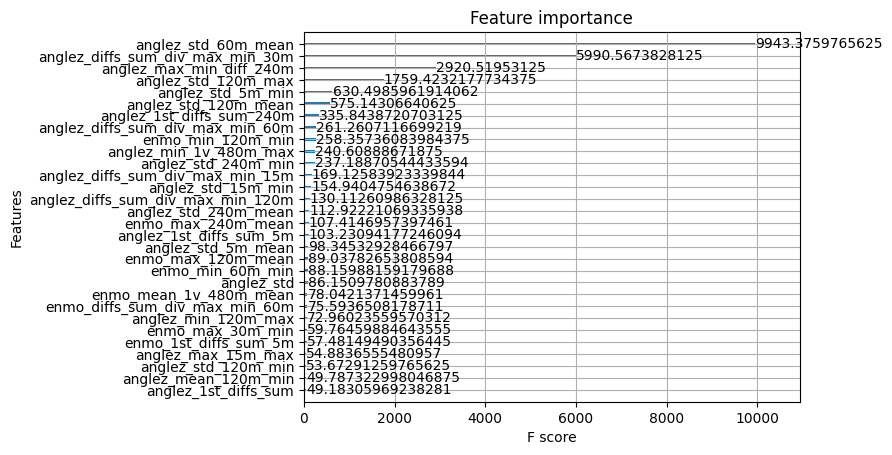

In [68]:
from xgboost import plot_importance
plot_importance(model, max_num_features=30, importance_type="gain");

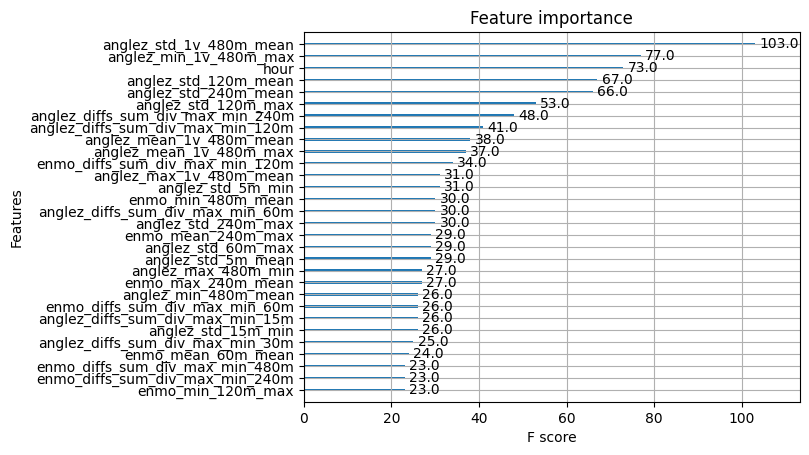

In [69]:
plot_importance(model, max_num_features=30, importance_type="weight");

In [96]:
# lot_importance(model, max_num_features=30, importance_type="cover");

NameError: name 'lot_importance' is not defined

In [97]:
model.feature_importances_

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [100]:
xgb_params

{'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'multi:softprob',
 'num_class': 3,
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'verbosity': 1}

#### sklearn API

In [ ]:
from xgboost import XGBClassifier
model_sklearn = XGBClassifier(
    xgb_params, 
    dtrain,
    evals=watchlist,
    verbose_eval=10, #print every 10 step
    num_boost_round=150 # with more we overfit
)
model_sklearn.fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_sklearn, X_val, y_val,n_repeats=30, random_state=0)